## Import

In [2]:
import pygdf
import numpy as np
from pygdf.dataframe import DataFrame
from numba import cuda
import json
from pyarrow import RecordBatchStreamReader
import sys, pandas as pd
from pygdf.gpuarrow import GpuArrowReader
import pygdf.gpuarrow as gpuarrow
from python_scripts.numbaHistinMem import numba_gpu_histogram
import matplotlib.pyplot as plt
%matplotlib inline

## Read dataframe from disk

In [3]:
def readArrowToDF(source):
    reader = RecordBatchStreamReader(source)
    pa_df = reader.read_all()
    return pa_df.to_pandas()
gdf_df = DataFrame.from_pandas(readArrowToDF("node_server/uploads/uber-dataset-v1.arrow"))

## tests

In [4]:
gdf_df.head().to_pandas()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,source_lat,source_long,dst_lat,dst_long
0,6,5,17,2917.18,790.28,2810.98,1.32,-121.948433,38.366653,-121.361717,38.554436
1,3,38,20,339.74,254.41,287.54,1.67,-121.660217,37.150475,-121.481194,37.205841
2,2,61,7,1443.36,374.62,1397.73,1.29,-122.219406,37.469585,-122.050941,37.561699
3,7,25,2,152.00,180.40,95.34,2.61,-121.996101,38.325848,-121.979637,38.343208
4,2,79,22,2320.41,324.85,2299.22,1.14,-122.219406,37.469585,-122.419426,37.790886


In [5]:
def transform(source_lat,source_long,dst_lat,dst_long,direction):
    for i, (w, x, y, z) in enumerate(zip(source_lat,source_long,dst_lat,dst_long)):
        if y-w>0:
            direction[i] = 1
        elif y-w<0:
            direction[i] = -1
        if z-x>0:
            direction[i] += 3
        elif z-x<0:
            direction[i] += 6
#     if gdf['source_lat'] - gdf['dest_lat'] > 0:
#         gdf['direction'] = North

In [6]:
val = gdf_df['source_lat'] - gdf_df['dst_lat']

In [7]:
a = gdf_df.apply_rows(transform,
                       incols=['source_lat','source_long','dst_lat','dst_long'],
                       outcols=dict(direction=np.float64),
                       kwargs=dict())

/conda/envs/gdf/lib/python3.6/site-packages/numba/cuda/compiler.py:236: UserWarning: Could not autotune, using default tpb of 128
  warnings.warn('Could not autotune, using default tpb of 128')


In [8]:
z = {1: 'north', -1: 'south', 3: 'west', 6: 'east', 4:'north east', 5: 'south west', 2: 'south east', 7:'north west'}

In [9]:
pd_df = a.to_pandas()

In [54]:
pd_df.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,source_lat,source_long,dst_lat,dst_long,direction
0,6,5,17,2917.18,790.28,2810.98,1.32,-121.948433,38.366653,-121.361717,38.554436,north east
1,3,38,20,339.74,254.41,287.54,1.67,-121.660217,37.150475,-121.481194,37.205841,north east
2,2,61,7,1443.36,374.62,1397.73,1.29,-122.219406,37.469585,-122.050941,37.561699,north east
3,7,25,2,152.00,180.40,95.34,2.61,-121.996101,38.325848,-121.979637,38.343208,north east
4,2,79,22,2320.41,324.85,2299.22,1.14,-122.219406,37.469585,-122.419426,37.790886,south east


In [10]:
pd_df['direction'] = pd_df['direction'].map(z)

In [29]:
result = pd_df.groupby(['hod','direction']).count()

In [34]:
result = result['sourceid']

In [37]:
result

hod  direction 
0    east               4
     north              5
     north east     80739
     north west    130584
     south              5
     south east    107804
     south west     62498
     west               3
1    east               4
     north              5
     north east     75713
     north west    121093
     south              4
     south east     95721
     south west     56795
     west               3
2    east               4
     north              5
     north east     64905
     north west    107398
     south              4
     south east     80409
     south west     51812
     west               3
3    east               3
     north              5
     north east     54501
     north west     91611
     south              3
     south east     75677
                    ...  
20   north east     92949
     north west    155408
     south              5
     south east    148887
     south west     81682
     west               3
21   east             

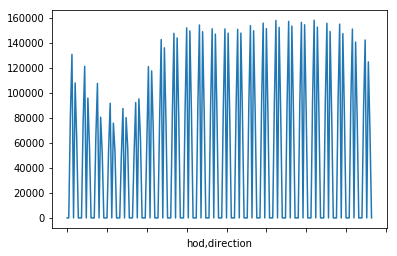

In [53]:
result.plot()
#     plt.subplot(2, 1, 1)
#     result[i]['direction'].plot(kind='bar')
#     plt.show()


In [ ]:
def transform_pandas(d):
    temp_str = ''
    if d['source_lat'] - d['dst_lat']>0:
        temp_str = 'north'
    elif d['source_lat'] - d['dst_lat']<0:
        temp_str = 'south'
    if d['source_long'] - d['dst_long']>0:
        temp_str += ' east'
    elif d['source_long'] - d['dst_long']<0:
        temp_str = ' west'
    return temp_str

In [ ]:
pd_df['direction'] = pd_df.apply(transform_pandas,axis=1)